In [1]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
import PIL.Image
from pathlib import Path
import torchvision

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import json
import time
import timm

In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
nfolds = 4
fname = 'resnext50'
IMAGE_DIR = '/kaggle/input/panda-16x128x128-tiles-data/train'
LABELS = '/kaggle/input/prostate-cancer-grade-assessment/train.csv'
SEED = 2024

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
loss_name = "mse"
TRAIN_DATASET_FRAC = 1
num_epochs = 20
EARLY_STOPPING = True
MIN_EPOCH = 10
PATIENCE = 8

## Seed everything

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## Dataset class

In [5]:
class ProstateTilesDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, n_tiles=(3, 4), transform=None):
        self.df = df
        self.image_dir = image_dir
        self.n_tiles = n_tiles  
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id = row.image_id
        label = row.isup_grade
        tile_rows, tile_cols = self.n_tiles
        imgs = []
        for i in range(tile_rows):
            for j in range(tile_cols):
                img_path = Path(self.image_dir, f'{img_id}_{i * tile_cols + j}.png')
                img = PIL.Image.open(img_path).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                imgs.append(img)
        imgs = torch.stack(imgs) # (12, 3, 128, 128)
        return imgs, label

## Model

In [6]:
class CustomPool(nn.Module):
    def __init__(self, N=12):
        super(CustomPool, self).__init__()
        self.avg_pool = nn.AvgPool1d(kernel_size=N)
        self.max_pool = nn.MaxPool1d(kernel_size=N)

    def forward(self, x):
        # x = (BS, 12, 2048)
        x = x.transpose(1, 2)  # (BS, 512, 12)
        avg_pooled = self.avg_pool(x).squeeze(-1)  # (BS, 512)
        max_pooled = self.max_pool(x).squeeze(-1)  # (BS, 512)
        concatenated_features = torch.cat((avg_pooled, max_pooled), dim=1)  # (BS, 512*2)
        return concatenated_features

In [7]:
class Model(nn.Module):
    def __init__(self, num_classes=1): # change back to 6
        super().__init__()
        self.enc = timm.create_model('resnext50_32x4d.fb_ssl_yfcc100m_ft_in1k', pretrained=True, num_classes=0)  
        nc = self.enc.feature_info[-1]['num_chs']
        self.pool = CustomPool()
        self.head = nn.Sequential(
            nn.Linear(nc*2,512), # (BS, 12, 512)
            nn.Mish(),
            nn.Dropout(0.25),
            nn.Linear(512,num_classes)
        )
        
    def forward(self, x):
        # x = (BS, 12, 3, 128, 128)
        n = x.shape[1]
        x = x.view(-1, x.shape[2], x.shape[3], x.shape[4]) # (BS*12, 3, 128, 128)
        x = self.enc(x) # (BS*12, nc)
        x = x.view(-1,n,x.shape[1]) # (BS, 12, nc)
        x = self.pool(x) # (BS, 512*2)
        x = self.head(x)
        return x

## Training utility functions

In [8]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    start_time = time.time()
    with tqdm(
        dataloader,
        desc=(f"Epoch {epoch} - Train"),
        unit=" slide",
        unit_scale=BATCH_SIZE,
        leave=False,
    ) as t:
        for inputs, labels in t:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float()
            outputs = model(inputs)
            if loss_name == "mse":
                loss = criterion(outputs.squeeze(-1), labels)
            else:
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
    
    average_loss = total_loss / len(dataloader)
    end_time = time.time()
    return average_loss

In [9]:
def go_from_mse_logit_to_prediction(logit):
    if logit < 0.5:
        return 0
    elif logit < 1.5:
        return 1
    elif logit < 2.5:
        return 2
    elif logit < 3.5:
        return 3
    elif logit < 4.5:
        return 4
    else:
        return 5

In [10]:
def tune(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    start_time = time.time()
    with tqdm(
        dataloader,
        desc=(f"Epoch {epoch} - Tune"),
        unit=" slide",
        unit_scale=BATCH_SIZE,
        leave=False,
    ) as t:
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float()
                outputs = model(inputs)
                if loss_name == "mse":
                    loss = criterion(outputs.squeeze(-1), labels)
                else:
                    loss = criterion(outputs, labels)
                total_loss += loss.item()
                if loss_name == "mse":
                    preds = [go_from_mse_logit_to_prediction(o) for o in outputs]
                else:
                    preds = outputs.argmax(dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

    average_loss = total_loss / len(dataloader)
    end_time = time.time()  
    elapsed_time = end_time - start_time 
    kappa = cohen_kappa_score(all_labels, all_preds, weights='quadratic')
    return average_loss, kappa, all_preds, all_labels

In [11]:
def log_metrics(epoch, fold, train_loss, tune_loss, kappa):
    logs = {'epoch': epoch, 'fold': fold, 'train_loss': train_loss, 'tune_loss': tune_loss, 'kappa': kappa}
    logs_folder = Path("/kaggle/working/logs")
    logs_folder.mkdir(exist_ok=True)
    log_file = Path(logs_folder, f'log_{fname}_{fold}.json')
    if log_file.is_file():
        with open(log_file, 'r') as file:
            data = json.load(file)
    else:
        data = []
    data.append(logs)
    with open(log_file, 'w') as file:
        json.dump(data, file)

In [12]:
def save_best_model(model, best_val, current_val, fold, epoch, min_max="min"):
    improve_flag = False
    if min_max == "max":
        best_val = -1 * best_val
        current_val = -1 * current_val
    if current_val < best_val:
        improve_flag = True
        best_val = current_val
        torch.save(model.state_dict(), f'{fname}_{fold}.pth')
        print(f"Saved better model for fold {fold} at epoch {epoch}")
    if min_max == "max":
        best_val = -1 * best_val
    return best_val, improve_flag

## Model training

In [13]:
df = pd.read_csv(LABELS)
df.head()

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [14]:
# grab slide ids in /kaggle/input/panda-16x128x128-tiles-data
slide_ids = list(set([fp.stem.split("_")[0] for fp in Path(IMAGE_DIR).glob("*.png")]))
len(slide_ids)

10516

In [15]:
# restrict previous dataframe to those ids
df_restricted = df[df.image_id.isin(slide_ids)].reset_index(drop=True)
len(df) - len(df_restricted)

100

In [16]:
skf = StratifiedKFold(n_splits=nfolds, random_state=SEED, shuffle=True)
X = df_restricted.image_id.values
y = df_restricted.isup_grade.values
train_dfs, tune_dfs = [], []
for i, (train_index, tune_index) in enumerate(skf.split(X, y)):
    train_df, tune_df = df_restricted.loc[train_index], df_restricted.loc[tune_index]
    if TRAIN_DATASET_FRAC < 1.0:
        train_df = train_df.sample(frac=TRAIN_DATASET_FRAC, random_state=SEED)
    train_df = train_df.reset_index(drop=True)
    tune_df = tune_df.reset_index(drop=True)
    train_dfs.append(train_df)
    tune_dfs.append(tune_df)
    print(f"fold {i+1}/{nfolds}: train={len(train_df)}, tune={len(tune_df)}")

fold 1/4: train=7887, tune=2629
fold 2/4: train=7887, tune=2629
fold 3/4: train=7887, tune=2629
fold 4/4: train=7887, tune=2629


In [17]:
mean = torch.tensor([1.0-0.90949707, 1.0-0.8188697, 1.0-0.87795304])
std = torch.tensor([0.36357649, 0.49984502, 0.40477625])

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),    
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
    
])

In [18]:
def show_image(img_tensor, title):
    img = img_tensor.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [20]:
all_folds_preds = []
all_folds_labels = []
for fold in range(nfolds):

    train_dataset = ProstateTilesDataset(train_dfs[fold], IMAGE_DIR, transform=transform)
    tune_dataset = ProstateTilesDataset(tune_dfs[fold], IMAGE_DIR, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    tune_loader = torch.utils.data.DataLoader(tune_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
    
    if loss_name == "mse":
        num_classes =  1
        criterion = nn.MSELoss()
    else:
        num_classes = 6
        criterion = nn.CrossEntropyLoss()
        
    model = Model(num_classes=num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_kappa = -np.inf
    best_loss = np.inf
    best_fold_dict = {
            "epochs": [None] * num_epochs,
            "kappa": [None] * num_epochs,
            "preds": [None] * num_epochs,
            "labels": [None] * num_epochs,
            "loss": [float('inf')] * num_epochs
        }


    
    early_stopping_count = 0
    
    with tqdm(
        range(num_epochs),
        desc=f"Fold {fold+1}/{nfolds}",
        unit=" epoch",
        leave=True,
    ) as t:
        for epoch in t:
            train_loss = train(model, train_loader, criterion, optimizer, device)
            tqdm.write(f"Epoch {epoch} - train_loss: {train_loss:.4f}")
            valid_loss, kappa, fold_preds, fold_labels = tune(model, tune_loader, criterion, device)
            tqdm.write(f"Epoch {epoch} - tune loss: {valid_loss:.4f}")
            tqdm.write(f"Epoch {epoch} - tune kappa: {kappa:.4f}")
            log_metrics(epoch, fold, train_loss, valid_loss, kappa)
        
            best_fold_dict["epochs"][epoch] = (epoch + 1)
            best_fold_dict["kappa"][epoch] = kappa
            best_fold_dict["preds"][epoch] = fold_preds
            best_fold_dict["labels"][epoch] = fold_labels
            best_fold_dict["loss"][epoch] = valid_loss

            
            # best_kappa, improve_flag = save_best_model(model, best_kappa, kappa, fold, epoch, min_max="max")
            best_loss, improve_flag = save_best_model(model, best_loss, valid_loss, fold, epoch,  min_max="min")
            if not improve_flag:
                early_stopping_count += 1
            if EARLY_STOPPING and early_stopping_count > PATIENCE and epoch >= MIN_EPOCH:
                print(f"Epoch {epoch} - Stopping early as model didn't improve over the last {PATIENCE} epochs")
                break
    
    
    # get best epoch based on lowest loss
    min_value_index = best_fold_dict['loss'].index(min(best_fold_dict['loss']))
    best_epoch = best_fold_dict['epochs'][min_value_index]
    loss_best = best_fold_dict['loss'][min_value_index]
    print(f'Best performing epoch of fold {fold +1} is {best_epoch} with a loss of {loss_best}')

    all_folds_preds.extend(best_fold_dict["preds"][min_value_index])
    all_folds_labels.extend(best_fold_dict["labels"][min_value_index])
    

model.safetensors:   0%|          | 0.00/100M [00:00<?, ?B/s]

Fold 1/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 3.5774


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.7191
Epoch 0 - tune kappa: 0.5721
Saved better model for fold 0 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.8460


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.7338
Epoch 1 - tune kappa: 0.6126


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.7630


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.5443
Epoch 2 - tune kappa: 0.6133
Saved better model for fold 0 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.6661


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 2.4479
Epoch 3 - tune kappa: 0.3622


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.6738


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 2.0766
Epoch 4 - tune kappa: 0.4625


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 1.6884


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.6292
Epoch 5 - tune kappa: 0.6359


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 1.5765


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.4477
Epoch 6 - tune kappa: 0.6749
Saved better model for fold 0 at epoch 6


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 1.5507


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.3869
Epoch 7 - tune kappa: 0.6641
Saved better model for fold 0 at epoch 7


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 1.5461


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.4561
Epoch 8 - tune kappa: 0.6486


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 1.5307


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.9941
Epoch 9 - tune kappa: 0.5727


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 1.5438


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.4651
Epoch 10 - tune kappa: 0.6686


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 1.4986


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.3440
Epoch 11 - tune kappa: 0.7042
Saved better model for fold 0 at epoch 11


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 1.4607


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.7529
Epoch 12 - tune kappa: 0.6049


Epoch 13 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 1.4013


Epoch 13 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.5768
Epoch 13 - tune kappa: 0.6296
Epoch 13 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 1 is 12 with a loss of 1.3439957334334591


Fold 2/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 3.5284


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.7178
Epoch 0 - tune kappa: 0.5277
Saved better model for fold 1 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.8019


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.5780
Epoch 1 - tune kappa: 0.6640
Saved better model for fold 1 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.7271


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.5897
Epoch 2 - tune kappa: 0.6170


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.6643


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 2.2954
Epoch 3 - tune kappa: 0.5076


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.6050


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.3635
Epoch 4 - tune kappa: 0.6843
Saved better model for fold 1 at epoch 4


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 1.5613


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.4504
Epoch 5 - tune kappa: 0.6427


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 1.6122


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.8888
Epoch 6 - tune kappa: 0.6350


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 1.5279


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.4981
Epoch 7 - tune kappa: 0.6731


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 1.5256


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.2879
Epoch 8 - tune kappa: 0.7120
Saved better model for fold 1 at epoch 8


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 1.4727


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.3569
Epoch 9 - tune kappa: 0.7196


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 1.4663


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.5400
Epoch 10 - tune kappa: 0.7160


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 1.4472


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.3153
Epoch 11 - tune kappa: 0.6964


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 1.4167


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.8887
Epoch 12 - tune kappa: 0.5833
Epoch 12 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 2 is 9 with a loss of 1.287881733423256


Fold 3/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 4.0669


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 2.1629
Epoch 0 - tune kappa: 0.6510
Saved better model for fold 2 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 1.8571


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.7996
Epoch 1 - tune kappa: 0.5354
Saved better model for fold 2 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 1.8120


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.7867
Epoch 2 - tune kappa: 0.5131
Saved better model for fold 2 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.7018


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.6325
Epoch 3 - tune kappa: 0.6722
Saved better model for fold 2 at epoch 3


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.6720


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.5509
Epoch 4 - tune kappa: 0.5920
Saved better model for fold 2 at epoch 4


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 1.6402


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.5165
Epoch 5 - tune kappa: 0.6710
Saved better model for fold 2 at epoch 5


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 1.6098


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 1.3724
Epoch 6 - tune kappa: 0.6906
Saved better model for fold 2 at epoch 6


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 1.5619


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.5562
Epoch 7 - tune kappa: 0.6647


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 1.5070


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 1.5445
Epoch 8 - tune kappa: 0.6153


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 1.4532


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.5247
Epoch 9 - tune kappa: 0.6346


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 1.4937


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 2.3408
Epoch 10 - tune kappa: 0.4874


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 1.4374


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.4026
Epoch 11 - tune kappa: 0.7354


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 1.4378


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 2.2410
Epoch 12 - tune kappa: 0.4399


Epoch 13 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 13 - train_loss: 1.4473


Epoch 13 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 13 - tune loss: 1.4944
Epoch 13 - tune kappa: 0.6133


Epoch 14 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 14 - train_loss: 1.4451


Epoch 14 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 14 - tune loss: 1.5494
Epoch 14 - tune kappa: 0.7052


Epoch 15 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 15 - train_loss: 1.4352


Epoch 15 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 15 - tune loss: 1.8246
Epoch 15 - tune kappa: 0.6028
Epoch 15 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 3 is 7 with a loss of 1.3723898731082318


Fold 4/4:   0%|          | 0/20 [00:00<?, ? epoch/s]

Epoch 0 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 0 - train_loss: 3.8847


Epoch 0 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 0 - tune loss: 1.7303
Epoch 0 - tune kappa: 0.5527
Saved better model for fold 3 at epoch 0


Epoch 1 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 1 - train_loss: 2.0463


Epoch 1 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 1 - tune loss: 1.5111
Epoch 1 - tune kappa: 0.6530
Saved better model for fold 3 at epoch 1


Epoch 2 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 2 - train_loss: 2.0120


Epoch 2 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 2 - tune loss: 1.4745
Epoch 2 - tune kappa: 0.6243
Saved better model for fold 3 at epoch 2


Epoch 3 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 3 - train_loss: 1.9669


Epoch 3 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 3 - tune loss: 1.9142
Epoch 3 - tune kappa: 0.5683


Epoch 4 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 4 - train_loss: 1.8728


Epoch 4 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 4 - tune loss: 1.4265
Epoch 4 - tune kappa: 0.6906
Saved better model for fold 3 at epoch 4


Epoch 5 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 5 - train_loss: 1.8070


Epoch 5 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 5 - tune loss: 1.5032
Epoch 5 - tune kappa: 0.5981


Epoch 6 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 6 - train_loss: 1.8204


Epoch 6 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 6 - tune loss: 4.0790
Epoch 6 - tune kappa: 0.1893


Epoch 7 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 7 - train_loss: 1.7542


Epoch 7 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 7 - tune loss: 1.5727
Epoch 7 - tune kappa: 0.5795


Epoch 8 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 8 - train_loss: 1.7398


Epoch 8 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 8 - tune loss: 2.0869
Epoch 8 - tune kappa: 0.5747


Epoch 9 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 9 - train_loss: 1.6912


Epoch 9 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 9 - tune loss: 1.4768
Epoch 9 - tune kappa: 0.6292


Epoch 10 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 10 - train_loss: 1.6491


Epoch 10 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 10 - tune loss: 1.7082
Epoch 10 - tune kappa: 0.6195


Epoch 11 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 11 - train_loss: 1.6261


Epoch 11 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 11 - tune loss: 1.5202
Epoch 11 - tune kappa: 0.5906


Epoch 12 - Train:   0%|          | 0/7904 [00:00<?, ? slide/s]

Epoch 12 - train_loss: 1.5287


Epoch 12 - Tune:   0%|          | 0/2656 [00:00<?, ? slide/s]

Epoch 12 - tune loss: 1.5594
Epoch 12 - tune kappa: 0.5950
Epoch 12 - Stopping early as model didn't improve over the last 8 epochs
Best performing epoch of fold 4 is 5 with a loss of 1.4265321414154697


Overall CV Score: 0.6994


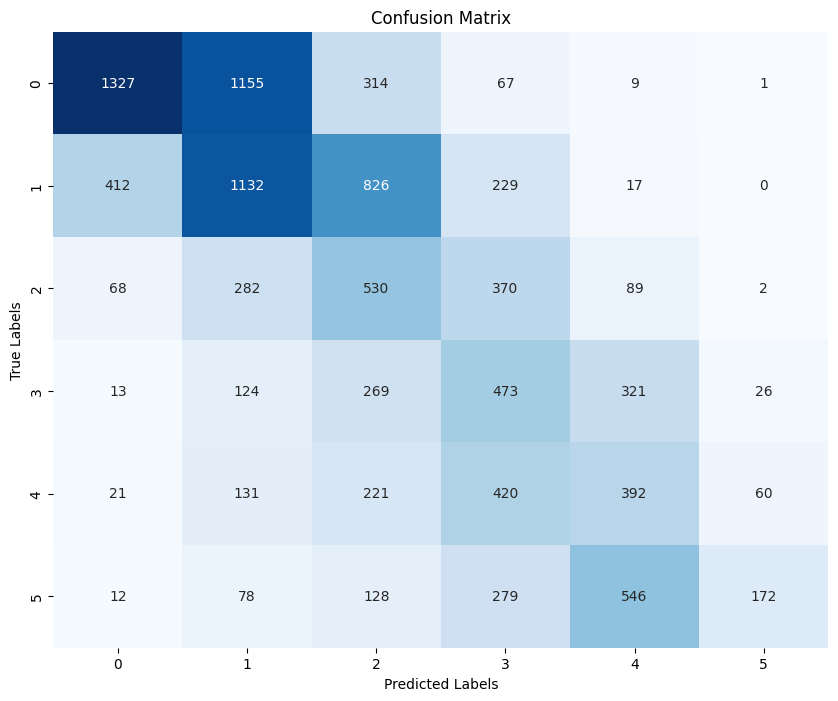

In [21]:
preds_array = np.array(all_folds_preds)
labels_array = np.array(all_folds_labels)

kappa_score = cohen_kappa_score(labels_array, preds_array, weights='quadratic')
print(f"Overall CV Score: {kappa_score:.4f}")

cm = confusion_matrix(labels_array, preds_array)

plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Plot loss curves 

{'epoch': 0, 'fold': 0, 'train_loss': 3.577397629558316, 'tune_loss': 1.7190772998763855, 'kappa': 0.5720800396130895}
{'epoch': 1, 'fold': 0, 'train_loss': 1.8459951213979529, 'tune_loss': 1.7337614599480686, 'kappa': 0.6126197419999232}
{'epoch': 2, 'fold': 0, 'train_loss': 1.763040754235225, 'tune_loss': 1.544309153614274, 'kappa': 0.6132879442358206}
{'epoch': 3, 'fold': 0, 'train_loss': 1.6661001258050865, 'tune_loss': 2.447949865496302, 'kappa': 0.3622117950547977}
{'epoch': 4, 'fold': 0, 'train_loss': 1.6738086873703157, 'tune_loss': 2.076623430453151, 'kappa': 0.4625254060232957}
{'epoch': 5, 'fold': 0, 'train_loss': 1.688442799967793, 'tune_loss': 1.6292196404503052, 'kappa': 0.63588510358764}
{'epoch': 6, 'fold': 0, 'train_loss': 1.5764962287566922, 'tune_loss': 1.447722269828061, 'kappa': 0.6749076439280004}
{'epoch': 7, 'fold': 0, 'train_loss': 1.5507468566720786, 'tune_loss': 1.3868871568197227, 'kappa': 0.6640541510687012}
{'epoch': 8, 'fold': 0, 'train_loss': 1.546135906

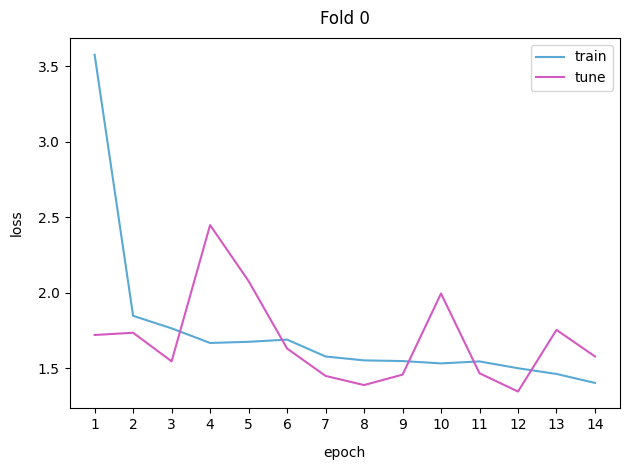

{'epoch': 0, 'fold': 1, 'train_loss': 3.5283760450146944, 'tune_loss': 1.7178245416606766, 'kappa': 0.527747101449521}
{'epoch': 1, 'fold': 1, 'train_loss': 1.8018989951504387, 'tune_loss': 1.5779992815959885, 'kappa': 0.6639900969014072}
{'epoch': 2, 'fold': 1, 'train_loss': 1.7271013937981023, 'tune_loss': 1.5897329219852585, 'kappa': 0.6170130430849123}
{'epoch': 3, 'fold': 1, 'train_loss': 1.6643424852174302, 'tune_loss': 2.2953926935253373, 'kappa': 0.507625811721852}
{'epoch': 4, 'fold': 1, 'train_loss': 1.6049841912651834, 'tune_loss': 1.3634656107569316, 'kappa': 0.6843208853373903}
{'epoch': 5, 'fold': 1, 'train_loss': 1.5613433257770923, 'tune_loss': 1.450419108551669, 'kappa': 0.6426763904012448}
{'epoch': 6, 'fold': 1, 'train_loss': 1.6121929922567206, 'tune_loss': 1.888847672795675, 'kappa': 0.6350255298396527}
{'epoch': 7, 'fold': 1, 'train_loss': 1.5279385720187353, 'tune_loss': 1.4981478862015598, 'kappa': 0.6730980181315589}
{'epoch': 8, 'fold': 1, 'train_loss': 1.5255

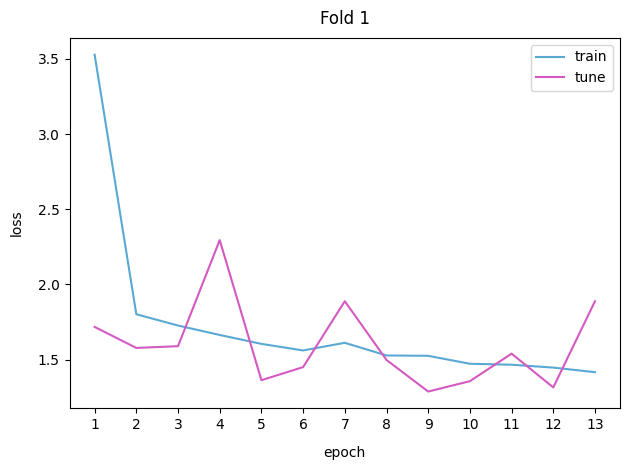

{'epoch': 0, 'fold': 2, 'train_loss': 4.066928291610378, 'tune_loss': 2.1629411958786378, 'kappa': 0.6510335678846395}
{'epoch': 1, 'fold': 2, 'train_loss': 1.8570831198441355, 'tune_loss': 1.7995517296963428, 'kappa': 0.5354322592350163}
{'epoch': 2, 'fold': 2, 'train_loss': 1.8120340461190414, 'tune_loss': 1.786680929632072, 'kappa': 0.5131233891107374}
{'epoch': 3, 'fold': 2, 'train_loss': 1.701787575295097, 'tune_loss': 1.6324778694704354, 'kappa': 0.6722496719825278}
{'epoch': 4, 'fold': 2, 'train_loss': 1.6720275770314792, 'tune_loss': 1.550927646906979, 'kappa': 0.5919865658844332}
{'epoch': 5, 'fold': 2, 'train_loss': 1.6401969981097018, 'tune_loss': 1.5165292200553848, 'kappa': 0.6709548147623015}
{'epoch': 6, 'fold': 2, 'train_loss': 1.6098355708817238, 'tune_loss': 1.3723898731082318, 'kappa': 0.6906044004457208}
{'epoch': 7, 'fold': 2, 'train_loss': 1.5619012254935045, 'tune_loss': 1.5561619264533721, 'kappa': 0.664692884410181}
{'epoch': 8, 'fold': 2, 'train_loss': 1.50698

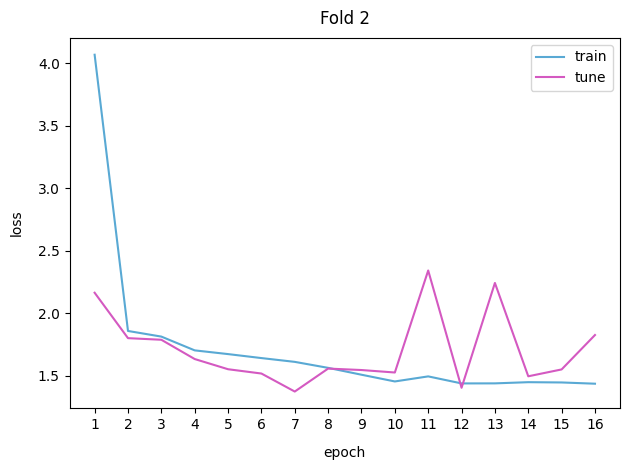

{'epoch': 0, 'fold': 3, 'train_loss': 3.884677363793377, 'tune_loss': 1.7302717264876308, 'kappa': 0.5526658205208225}
{'epoch': 1, 'fold': 3, 'train_loss': 2.0463135295551313, 'tune_loss': 1.511097708380366, 'kappa': 0.6529605034096688}
{'epoch': 2, 'fold': 3, 'train_loss': 2.0120110456277485, 'tune_loss': 1.4745228850697896, 'kappa': 0.6242772262109794}
{'epoch': 3, 'fold': 3, 'train_loss': 1.9668702188773677, 'tune_loss': 1.914219087146851, 'kappa': 0.5683235706396694}
{'epoch': 4, 'fold': 3, 'train_loss': 1.8727879948944215, 'tune_loss': 1.4265321414154697, 'kappa': 0.6906130929314674}
{'epoch': 5, 'fold': 3, 'train_loss': 1.8069659358094097, 'tune_loss': 1.5031811666775898, 'kappa': 0.5980830705202231}
{'epoch': 6, 'fold': 3, 'train_loss': 1.8204016391082332, 'tune_loss': 4.078980629702649, 'kappa': 0.1893189542658541}
{'epoch': 7, 'fold': 3, 'train_loss': 1.7541843828884696, 'tune_loss': 1.572676762040839, 'kappa': 0.5794784622931501}
{'epoch': 8, 'fold': 3, 'train_loss': 1.73975

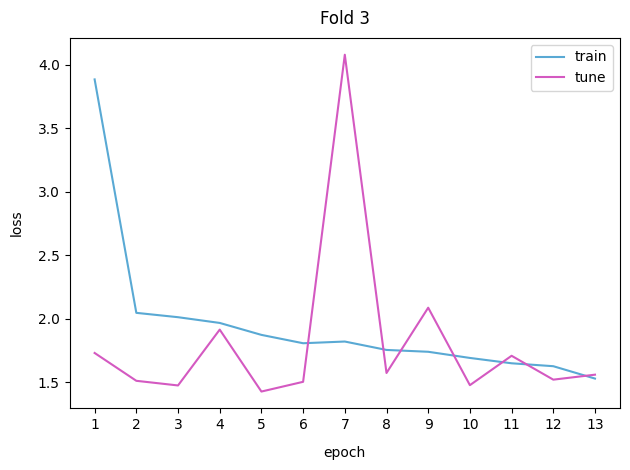

In [24]:
import matplotlib.pyplot as plt

for fold in range(nfolds):
    with open(f'/kaggle/working/logs/log_{fname}_{fold}.json') as f:
        d = json.load(f)
        epoch = []
        train_loss = []
        tune_loss = []
        kappa = []
        for sd in d:
            print(sd)
            epoch.append(sd['epoch'])
            train_loss.append(sd['train_loss'])
            tune_loss.append(sd['tune_loss'])
            kappa.append(sd['kappa'])

    

    plt.figure(dpi=100)
    plt.plot(train_loss, label='train', color="#59A9D4")
    plt.plot(tune_loss, label='tune', color="#D459C1")

    plt.title(f'Fold {fold}', pad=10)
    plt.xlabel('epoch', labelpad=10)
    plt.ylabel('loss', labelpad=10)
    plt.xticks(range(len(train_loss)), range(1, len(train_loss)+1))  # Assuming epochs start at 1
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'log_{fname}_{fold}.png')
    plt.show()